In [68]:
# Importação das bibliotecas necessárias
import spacy
import re
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from gensim.matutils import corpus2dense
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF
from scipy.spatial.distance import cosine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings


In [3]:
path = "data/sentenças_educacao.xlsx"

# Part 1 - LLM

## Input de Docs com prompt
Input dos docs em um modelo LLM com prompt dedicado a clusterizar os textos da melhor forma possível explicando cada tópico e dando output do número de tópicos.

In [4]:
# Will be applied after due to cost of running an LLM locally

# Will be assumed a that the LLM will output 8 clusters of topics

In [4]:
# Output do LLM será inserido aqui
llm_guess = 8

# Part 2 - NLP 

### Settando Variáveis

In [5]:
# Palavras personalizadas para remoção
custom_words = {
    "alguns", "pouco", "muito", "toda", "todo", "algum", "certo",
    "vários", "nenhum", "tanto", "quanto", "tudo", "nada", "exmo",
    "provimento", "termos", "voto", "exmo", "relator", "juizes", "que",
    "turma", "recursal", "jecs", "unanimidade", "conhecer", "recurso",
    "nos", "termos", "do", "voto", "do", "exmo", "relator", "integram",
    'ilustre', 'dr', 'art', 'lei', 'nao', 'artigo', 'vi', 'vii', 'iv', 'iii',
    'ii', 'i', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv',
    ''
}

In [6]:
# Carregar o modelo de linguagem Português
nlp = spacy.load("pt_core_news_sm")
nlp.Defaults.stop_words |= custom_words  # Adicionando stopwords personalizadas


In [7]:
df = pd.read_excel(path)
docs = df.iloc[:, 2].tolist()

### Dividindo Dataset em Batches

In [8]:
def separar_docs(docs, n):
    """
    Separa os docs em n subcorpora.
    """
    np.random.shuffle(docs)
    tamanho_subcorpus = len(docs) // n
    batches = [
        docs[i * tamanho_subcorpus: (i + 1) * tamanho_subcorpus]
        for i in range(n)
    ]
    return batches

In [9]:
batched_docs = separar_docs(docs, 3)

### Pré-Processamento

In [10]:
#Carregar e preprocessar o corpus
def preprocessar(docs, nlp):
    def limpar_texto(texto):
        texto = re.sub(r"<.*?>", "", texto)
        texto = re.sub(r"[^\w\s]", "", texto)
        texto = re.sub(r"\s+", " ", texto)
        texto = re.sub(r"[^\x00-\x7F]+", " ", texto)
        texto = re.sub(r"\d[a|o]", "", texto)
        texto = re.sub(r'(\w+?)(lhe|lhes)\b', r'\1', texto)
        return texto

    def preprocessar_texto(texto):
        texto_limpo = limpar_texto(texto)
        doc = nlp(texto_limpo)
        tokens = [
            token.lower_
            for token in doc
            if not token.is_stop 
            and not token.is_punct
            and not token.like_num
            ]
        return tokens

    corpus_preprocessado = [preprocessar_texto(doc) for doc in docs]
    return corpus_preprocessado

In [38]:
def create_dictionary(processed_docs):
    dictionary = Dictionary([word for doc in batch for word in doc] for batch in processed_docs)
    return dictionary

In [39]:
processed_docs = [preprocessar(batch, nlp) for batch in batched_docs]
dictionary = create_dictionary(processed_docs)

### Aplicando BOW

In [40]:
#Doc to Bow (Bag of Words)
def doc_to_bow(corpus_preprocessado, dictionary):
    bow_corpus = [dictionary.doc2bow(doc) for doc in corpus_preprocessado]
    return bow_corpus

### Aplicando TF-IDF

In [42]:
#Vetorizar TF-IDF o corpus
def vetorizar_corpus(corpus_preprocessado, dictionary):
    corpus_texto = [' '.join(doc) for doc in corpus_preprocessado]
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.80, 
        min_df=3,
        vocabulary=dictionary.token2id,
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_texto)
    return tfidf_matrix, tfidf_vectorizer

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=3)

In [23]:
tfidf_matrices = [vetorizar_corpus(batch) for batch in processed_docs]

### Confronto de Bag of Words

A similaridade do cosseno é uma medida que calcula o cosseno do ângulo entre dois vetores. É útil para medir a similaridade entre documentos representados como vetores BoW.

In [43]:
# Gerar BoW e TF-IDF para cada batch
bow_results = [doc_to_bow(batch, dictionary) for batch in processed_docs]
tfidf_results = [vetorizar_corpus(batch, dictionary) for batch in processed_docs]

In [78]:
distances_data = []

# Comparar BoW com TF-IDF
for batch_idx, (bow_result, tfidf_result) in enumerate(
    zip(bow_results, tfidf_results)
    ):
    
    bow_corpus = bow_result
    tfidf_matrix, tfidf_vectorizer = tfidf_result

    # Converter BoW para matriz densa
    bow_matrix = corpus2dense(bow_corpus, num_terms=len(dictionary)).T

    # Garantir que ambas as matrizes tenham o mesmo vocabulário
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    bow_feature_names = [dictionary[i] for i in range(len(dictionary))]
    
    if set(tfidf_feature_names) != set(bow_feature_names):
        print(f"Vocabulário diferente no batch {batch_idx}.")
        continue

    # Comparar documentos usando a distância do cosseno
    for doc_idx in range(len(bow_matrix)):
        bow_vec = bow_matrix[doc_idx]
        tfidf_vec = tfidf_matrix[doc_idx].toarray().flatten()
        
        # Calcular a distância do cosseno entre BoW e TF-IDF
        distance = cosine(bow_vec, tfidf_vec)
        distances_data.append({
            "batch_idx": batch_idx,
            "doc_idx": doc_idx,
            "distance": distance
        })
        
distances_df = pd.DataFrame(distances_data)

/Users/etorebraga/Library/Caches/pypoetry/virtualenvs/topic-modeling-paper-aq0E2InM-py3.12/lib/python3.12/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [77]:
# Resumo estatístico por batch
summary_by_batch = distances_df.groupby('batch_idx')['distance'].describe()
print(summary_by_batch)

           count      mean       std  min       25%       50%       75%  \
batch_idx                                                                 
0           44.0  0.070110  0.047913  0.0  0.037284  0.059231  0.107175   
1           44.0  0.050727  0.034233  0.0  0.022300  0.037434  0.081187   
2           44.0  0.064745  0.047961  0.0  0.016480  0.055532  0.114481   

                max  
batch_idx            
0          0.251506  
1          0.122566  
2          0.152462  


/Users/etorebraga/Library/Caches/pypoetry/virtualenvs/topic-modeling-paper-aq0E2InM-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/etorebraga/Library/Caches/pypoetry/virtualenvs/topic-modeling-paper-aq0E2InM-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/etorebraga/Library/Caches/pypoetry/virtualenvs/topic-modeling-paper-aq0E2InM-py3.12/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to p

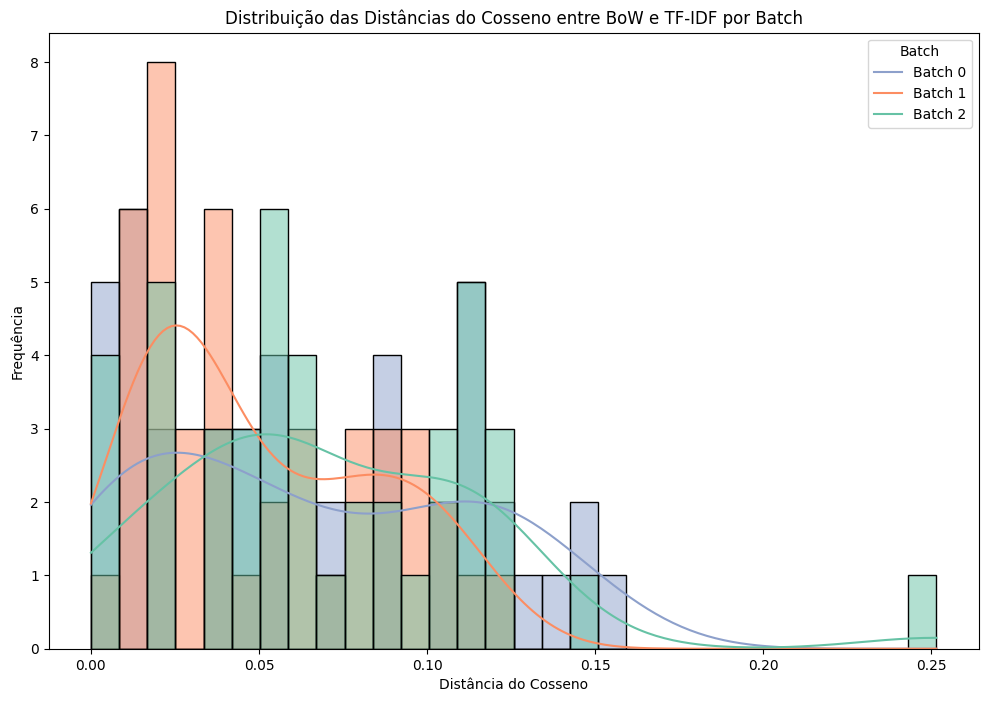

In [74]:
plt.figure(figsize=(12, 8))
sns.histplot(
    data=distances_df,
    x='distance',
    hue='batch_idx',
    bins=30,
    kde=True, 
    palette='Set2'
)
plt.title(
    'Distribuição das Distâncias do Cosseno entre BoW e TF-IDF por Batch'
)
plt.xlabel('Distância do Cosseno')
plt.ylabel('Frequência')
plt.legend(
    title='Batch',
    loc='upper right',
    labels=['Batch 0', 'Batch 1', 'Batch 2']
)
plt.show()

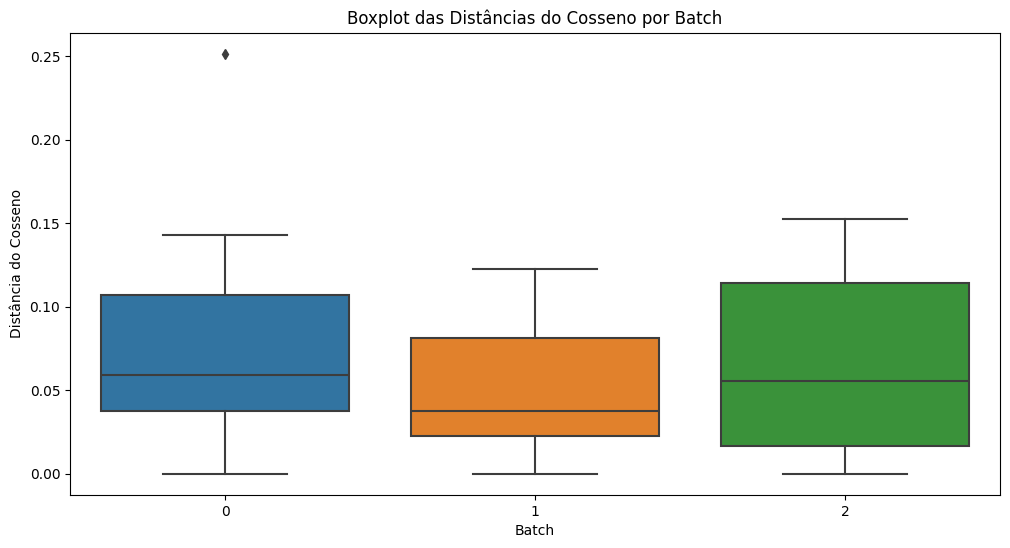

In [56]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='batch_idx', y='distance', data=distances_df)
plt.title('Boxplot das Distâncias do Cosseno por Batch')
plt.xlabel('Batch')
plt.ylabel('Distância do Cosseno')
plt.show()

## Aplicação das Técnicas

## ATUALIZAÇÃO:
Utilização das técnicas de NMF, LDA e LSA no intuito de encontrar a melhor técnica possível para utilização no modelo. A intenção é checar por meio do coherence score qual a técnica mais indicado para utilização no modelo com o corpus de sentenças.

### NMF

### Non-negative matrix factorization
A group of algorithms in multivariate analysis and linear algebra
#### Definition:
Factorizes a matrix V into two matrices W and H, ensuring all matrices have no negative elements.
#### Purpose:
Makes resulting matrices easier to inspect and is applicable where non-negativity is inherent, such as audio spectrograms or muscular activity data.
#### Solution Nature:
The problem is not exactly solvable in general and is usually approximated numerically.


**Reference:**
Lee DD, Seung HS. Learning the parts of objects by non-negative matrix factorization. Nature. 1999 Oct 21;401(6755):788-91. doi: 10.1038/44565. PMID: 10548103.

In [33]:
# Aplicar NMF
def aplicar_nmf(tfidf_matrix, n_topics):
    nmf_model = NMF(n_components=n_topics, random_state=42)
    nmf_model.fit(tfidf_matrix)
    return nmf_model

In [34]:
nmf_models = [aplicar_nmf(tfidf_matrix, 3) for tfidf_matrix, _ in tfidf_matrices]

In [35]:
nmf_models

[NMF(n_components=3, random_state=42),
 NMF(n_components=3, random_state=42),
 NMF(n_components=3, random_state=42)]

Incluir frequencia de cada palavra

In [74]:
# Extrair tópicos
def extrair_top_palavras_nmf(nmf_model, tfidf_vectorizer, top_n=10):
    palavras = np.array(tfidf_vectorizer.get_feature_names_out())
    top_palavras = []
    for topic in nmf_model.components_:
        top_palavras.append([palavras[i] for i in topic.argsort()[-top_n:]])
    return top_palavras

In [75]:
top_palavras_nmf = [
    extrair_top_palavras_nmf(
        nmf_models[i],
        tfidf_matrices[i][1]
        ) 
    for i in range(len(nmf_models))
    ]

In [76]:
top_palavras_nmf[0]

[['conforme',
  'condenado',
  'valendo',
  'federal',
  'acordao',
  'recorrente',
  'art',
  'disposto',
  'lei',
  'artigo'],
 ['caput',
  'hipotese',
  'prevista',
  'verificada',
  'dano',
  'onus',
  'sucumbenciais',
  'parcial',
  'artigo',
  'nao'],
 ['cpc',
  'honorarios',
  'custas',
  'negar',
  'legal',
  'julgamento',
  'ministerio',
  'presente',
  'fazendaria',
  'publico']]

In [77]:
# Calcular o Coherence Score
def calcular_coerencia_nmf(top_palavras, corpus_preprocessado, dictionary):
    coherence_model = CoherenceModel(
        topics=top_palavras,
        texts=corpus_preprocessado,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [78]:
nmf_scores = [
    calcular_coerencia_nmf(
        top_palavras_nmf[i],
        processed_docs[i],
        Dictionary(processed_docs[i])
    ) 
    for i in range(len(top_palavras_nmf))
]

In [79]:
nmf_scores

[0.8892691695363256, 0.8632013891759117, 0.9231895296742403]

In [80]:
nmf_topics = [[f"{' '.join(top_palavras_nmf[i][j])}" for j in range(3)] for i in range(len(top_palavras_nmf))]

In [54]:
nmf_whole = [
    {'modelo': nmf_models[i],
     'score': nmf_scores[i],
     'topicos': nmf_topics[i]} 
     for i in range(len(nmf_topics))
]

In [81]:
df_nmf = pd.DataFrame(nmf_whole)
df_nmf

,modelo,score,topicos
0,"NMF(n_components=3, random_state=42)",0.889269,[conforme condenado valendo federal acordao re...
1,"NMF(n_components=3, random_state=42)",0.863201,[honorarios custas manter fundamentos proprios...
2,"NMF(n_components=3, random_state=42)",0.923190,[regimento turmas interno tjrj transcricao dis...


### LDA

### Latent Dirichlet allocation
A generative statistical model in natural language processing
#### Definition
A Bayesian network and generative statistical model used for modeling automatically extracted topics in textual corpora.
#### Purpose
To analyze and represent written texts by identifying common themes and topics
#### Solution Nature
A machine learning methodology that uses Bayesian probability-based algorithms to discover latent topics based on co-occurrence of words from within a body of text (corpus)


**References:** 
David M. Blei, Andrew Y. Ng, and Michael I. Jordan. 2003. Latent dirichlet allocation. J. Mach. Learn. Res. 3, null (3/1/2003), 993–1022.

In [59]:
# Aplicar LDA
def aplicar_lda(tfidf_matrix, n_topics):
    """
    Aplica o modelo LDA em uma matriz TF-IDF.
    """
    lda_model = LDA(n_components=n_topics, random_state=42)
    lda_topics = lda_model.fit_transform(tfidf_matrix)
    return lda_model, lda_topics

In [61]:
lda_models = [aplicar_lda(tfidf_matrix, 3) for tfidf_matrix, _ in tfidf_matrices]

In [66]:
lda_models

[(LatentDirichletAllocation(n_components=3, random_state=42),
  array([[0.04069785, 0.91835711, 0.04094505],
         [0.33333333, 0.33333333, 0.33333333],
         [0.04385131, 0.91205568, 0.04409302],
         [0.33333333, 0.33333333, 0.33333333],
         [0.04347648, 0.9123354 , 0.04418812],
         [0.53909302, 0.41786813, 0.04303885],
         [0.04048864, 0.91853634, 0.04097502],
         [0.0483901 , 0.90325712, 0.04835278],
         [0.0483901 , 0.90325712, 0.04835278],
         [0.09916226, 0.10050819, 0.80032955],
         [0.06374425, 0.78178512, 0.15447063],
         [0.66482841, 0.16684826, 0.16832333],
         [0.53826938, 0.41949684, 0.04223378],
         [0.50946163, 0.42204951, 0.06848886],
         [0.04348594, 0.91286497, 0.04364909],
         [0.05760581, 0.88549541, 0.05689879],
         [0.04036234, 0.91907387, 0.0405638 ],
         [0.04604119, 0.90264645, 0.05131236],
         [0.08403988, 0.84036282, 0.07559731],
         [0.07982012, 0.09412431, 0.82605557]

In [67]:
def extrair_top_palavras_lda(lda_model, tfidf_vectorizer, top_n=10):
    """
    Extrai as top N palavras de cada tópico do modelo LDA.
    """
    palavras = np.array(tfidf_vectorizer.get_feature_names_out())
    top_palavras = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_palavras.append([palavras[i] for i in topic.argsort()[-top_n:]])
    return top_palavras

In [83]:
top_palavras_lda = [extrair_top_palavras_lda(lda_models[i][0], tfidf_matrices[i][1]) for i in range(len(lda_models))]

In [84]:
top_palavras_lda[0]

[['mantida',
  'verificada',
  'hipotese',
  'prevista',
  'caput',
  'nao',
  'dano',
  'onus',
  'sucumbenciais',
  'parcial'],
 ['fundamentos',
  'proprios',
  'recorrente',
  'valendo',
  'federal',
  'acordao',
  'disposto',
  'art',
  'lei',
  'artigo'],
 ['custas',
  'cpc',
  'negar',
  'legal',
  'presente',
  'ministerio',
  'fazendaria',
  'julgamento',
  'iv',
  'publico']]

In [86]:
def calcular_coerencia_lda(top_palavras, corpus_preprocessado, dictionary):
    """
    Calcula o Coherence Score para os tópicos gerados pelo LDA.
    """
    coherence_model = CoherenceModel(
        topics=[[word for word in topic if word in dictionary.token2id] 
                for topic in top_palavras],
        texts=corpus_preprocessado,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score


In [87]:
lda_scores = [
    calcular_coerencia_lda(
        top_palavras_lda[i],
        processed_docs[i],
        Dictionary(processed_docs[i])
    ) 
    for i in range(len(top_palavras_lda))
]

In [88]:
lda_scores

[0.8610600604520294, 0.6840876357921323, 0.882489902729031]

In [89]:
lda_topics = [[f"{' '.join(top_palavras_lda[i][j])}" for j in range(3)] for i in range(len(top_palavras_lda))]

In [90]:
lda_whole = [
    {'modelo': lda_models[i],
     'score': lda_scores[i],
     'topicos': lda_topics[i]} 
     for i in range(len(lda_topics))
]

In [92]:
df_lda = pd.DataFrame(lda_whole)
df_lda

,modelo,score,topicos
0,"(LatentDirichletAllocation(n_components=3, ran...",0.861060,[mantida verificada hipotese prevista caput na...
1,"(LatentDirichletAllocation(n_components=3, ran...",0.684088,[fundamentos recorrente principios sendo feder...
2,"(LatentDirichletAllocation(n_components=3, ran...",0.882490,[instancia oficial janeiro rio capital outubro...


### LSA

### Latent semantic analysis
A technique in natural language processing of analyzing document-term 
relationships
#### Definition
Latent semantic analysis (LSA) is a natural language processing technique for analyzing relationships between documents and the terms they contain, by producing concepts related to the documents and terms.
#### Purpose
To address issues of synonymy and polysemy in text retrieval by establishing associations between documents and terms
#### Solution Nature
LSA utilizes Singular Value Decomposition (SVD) to find the latent semantic structure of words spread across documents

**Reference**: 
Deerwester, S., Dumais, S.T., Furnas, G.W., Landauer, T.K. and Harshman, R. (1990), Indexing by latent semantic analysis. J. Am. Soc. Inf. Sci., 41: 391-407. https://doi.org/10.1002/(SICI)1097-4571(199009)41:6<391::AID-ASI1>3.0.CO;2-9

In [101]:
# Aplicar LSA
def aplicar_lsa(tfidf_matrix, n_topics):
    """
    Aplica o modelo LSA em uma matriz TF-IDF.
    """
    lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa_model.fit(tfidf_matrix)
    return lsa_model


In [104]:
lsa_models = [aplicar_lsa(tfidf_matrix, 3) for tfidf_matrix, _ in tfidf_matrices]

In [105]:
lsa_models

[TruncatedSVD(n_components=3, random_state=42),
 TruncatedSVD(n_components=3, random_state=42),
 TruncatedSVD(n_components=3, random_state=42)]

In [102]:
# 4. Extrair tópicos
def extrair_top_palavras_lsa(lsa_model, tfidf_vectorizer, top_n=10):
    """
    Extrai as top N palavras de cada tópico do modelo LSA.
    """
    palavras = np.array(tfidf_vectorizer.get_feature_names_out())
    top_palavras = []
    for topic in lsa_model.components_:
        top_palavras.append([palavras[i] for i in topic.argsort()[-top_n:]])
    return top_palavras

In [106]:
top_palavras_lsa = [extrair_top_palavras_lsa(lsa_models[i], tfidf_matrices[i][1]) for i in range(len(lsa_models))]

In [107]:
top_palavras_lsa[0]

[['fundamentos',
  'resolucao',
  'valendo',
  'recorrente',
  'acordao',
  'federal',
  'art',
  'disposto',
  'lei',
  'artigo'],
 ['caput',
  'verificada',
  'prevista',
  'mantida',
  'parcial',
  'sucumbenciais',
  'onus',
  'dano',
  'nao',
  'artigo'],
 ['iv',
  'negar',
  'legal',
  'parcial',
  'nao',
  'presente',
  'ministerio',
  'fazendaria',
  'julgamento',
  'publico']]

In [103]:
# Calcular o Coherence Score
def calcular_coerencia_lsa(top_palavras, corpus_preprocessado, dictionary):
    """
    Calcula o Coherence Score para os tópicos gerados pelo LSA.
    """
    coherence_model = CoherenceModel(
        topics=[[word for word in topic if word in dictionary.token2id] 
                for topic in top_palavras],
        texts=corpus_preprocessado,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [108]:
lsa_scores = [calcular_coerencia_lsa(top_palavras_lsa[i], processed_docs[i], Dictionary(processed_docs[i])) for i in range(len(top_palavras_lsa))]

In [110]:
lsa_scores

[0.7664024517729856, 0.9037100442133043, 0.9267319723514312]

In [112]:
lsa_topics = [[f"{' '.join(top_palavras_lsa[i][j])}" for j in range(3)] for i in range(len(top_palavras_lsa))] 

In [113]:
lsa_whole = [{'modelo': lsa_models[i], 'score': lsa_scores[i], 'topicos': lsa_topics[i]} for i in range(len(lsa_topics))]

In [115]:
df_lsa = pd.DataFrame(lsa_whole)
df_lsa

,modelo,score,topicos
0,"TruncatedSVD(n_components=3, random_state=42)",0.766402,[fundamentos resolucao valendo recorrente acor...
1,"TruncatedSVD(n_components=3, random_state=42)",0.903710,[resolucao principios sendo recorrente federal...
2,"TruncatedSVD(n_components=3, random_state=42)",0.926732,[valendo federal condenado honorarios custas r...


### Análise da Coerência dos modelos

In [122]:
resultados = {'nmf': df_nmf, 'lda': df_lda, 'lsa': df_lsa}

In [123]:
dfs = []
for modelo_tipo, df in resultados.items():
    df['modelo_tipo'] = modelo_tipo
    dfs.append(df)

# Concatenar todos os dataframes
df_resultados = pd.concat(dfs, ignore_index=True)

df_resultados

,modelo,score,topicos,modelo_tipo
0,"NMF(n_components=3, random_state=42)",0.889269,[conforme condenado valendo federal acordao re...,nmf
1,"NMF(n_components=3, random_state=42)",0.863201,[honorarios custas manter fundamentos proprios...,nmf
2,"NMF(n_components=3, random_state=42)",0.923190,[regimento turmas interno tjrj transcricao dis...,nmf
3,"(LatentDirichletAllocation(n_components=3, ran...",0.861060,[mantida verificada hipotese prevista caput na...,lda
4,"(LatentDirichletAllocation(n_components=3, ran...",0.684088,[fundamentos recorrente principios sendo feder...,lda
5,"(LatentDirichletAllocation(n_components=3, ran...",0.882490,[instancia oficial janeiro rio capital outubro...,lda
6,"TruncatedSVD(n_components=3, random_state=42)",0.766402,[fundamentos resolucao valendo recorrente acor...,lsa
7,"TruncatedSVD(n_components=3, random_state=42)",0.903710,[resolucao principios sendo recorrente federal...,lsa
8,"TruncatedSVD(n_components=3, random_state=42)",0.926732,[valendo federal condenado honorarios custas r...,lsa


## Atualização: 
Os dados demonstraram um problema de interpretabilidade nos termos de frequencia devido a primeira passagem pelo modelo não haver o ajuste da técnica de Bag of Words para ser possível concentrar semanticamente alguns termos e assim gerar dados mais densos. 

## Análise de Coesão dos Grupos

In [ ]:
Matrix de Instabilidade -> aplicar ||| 
Método de Frobenius -> histograma de palavras mais coerentes e menos coerentes


In [ ]:
Análise de Coesão dos Grupo -> kmeans.clusters fit(x) {Coesão} 
-> kmeans.Inertia [evitar negativos] {Distinção} ->
kmeans.silluette_score {Relação entre Coesão e Distinção} [coeficiente hand - eval]

In [ ]:
Falsos Positivos e Negativos de Cada Tópico -> Justificativa -> 
Passa por LSA (Importancia Semantica) | pLSA (Probabilistica Importancia Semantica)
->  modelo exato [MUITO IMPORTANTE] | cluster abrangente [POUCO IMPORTANTE]

In [ ]:
Calibragem de Modelo -> "Aleatório" -> 